In [1]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import pickle

In [2]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"
df = get_match_data(base_url.format(season))
ws = get_winstreak(df)

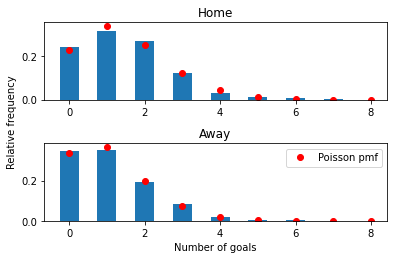

In [3]:
### Histogram of home and away goals
fig, axs = plt.subplots(2,1)
bins = [i for i in range(9)]

axs[0].hist(df["FTHG"], density=True,bins=bins, align="left", rwidth=0.5)
axs[1].hist(df["FTAG"], density=True,bins=bins, align="left", rwidth=0.5)
axs[0].set_title("Home")
axs[1].set_title("Away")

home_mean = df.mean(axis=0)["FTHG"]
away_mean = df.mean(axis=0)["FTAG"]

axs[0].plot(bins, poisson.pmf(bins, home_mean), 'ro', label="Poisson pmf")
axs[1].plot(bins, poisson.pmf(bins, away_mean), 'ro',label="Poisson pmf")
plt.legend()

### Common axes labels
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.xlabel("Number of goals")
plt.ylabel("Relative frequency")
plt.tight_layout()

# plt.savefig("figures/poisson_frequency.jpeg", dpi=300)

In [4]:
### Chi-sq goodness of fit test

### Home
home_mean = df.mean(axis=0)["FTHG"]
home_count = df["FTHG"].value_counts(sort=False) # 5 or more

home_count = [home_count[i] for i in range(4)]
home_count.append(380 - sum(home_count))
home_count = np.array(home_count)

home_expected = [poisson.pmf(i, home_mean) * 380 for i in range(4)]
home_expected.append(380 - sum(home_expected))
home_expected = np.array(home_expected)


### Away
away_mean = df.mean(axis=0)["FTAG"]
away_count = df["FTAG"].value_counts(sort=False) # 4 or more

away_count = [away_count[i] for i in range(4)]
away_count.append(380 - sum(away_count))
away_count = np.array(away_count)

away_expected = [poisson.pmf(i, away_mean) * 380 for i in range(4)]
away_expected.append(380 - sum(away_expected))
away_expected = np.array(away_expected)

### Test results:
print(chisquare(home_count,home_expected, ddof=1))
print(chisquare(away_count,away_expected, ddof=1))

Power_divergenceResult(statistic=1.8572927713287892, pvalue=0.6025474430859525)
Power_divergenceResult(statistic=1.1850001915376027, pvalue=0.7566040876792556)


In [5]:
### Gradient descent / NO MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
params = np.ones((4,20))

num_itrs = 100000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])


100%|██████████| 100000/100000 [04:54<00:00, 339.43it/s]


In [6]:
### Gradient descent / MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
team_params = np.ones((4,20))
streak_param = 1

num_itrs = 100000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]
        week = row["MatchWeek"]
        home_streak = ws.loc[week,row["HomeTeam"]]
        away_streak = ws.loc[week,row["AwayTeam"]]

        # update home team params
        team_params[0,home_index] += lr * (home_goal / team_params[0,home_index] - team_params[3,away_index] * (streak_param ** home_streak))
        team_params[1,home_index] += lr * (away_goal / team_params[1,home_index] - team_params[2,away_index] * (streak_param ** away_streak))
        if home_streak != 0:
            streak_param += lr * (home_goal * home_streak / streak_param - home_streak * team_params[0,home_index] * team_params[3,away_index] * (streak_param ** (home_streak - 1)))

        # update away team params
        team_params[2,away_index] += lr * (away_goal / team_params[2,away_index] - team_params[1,home_index] * (streak_param ** away_streak))
        team_params[3,away_index] += lr * (home_goal / team_params[3,away_index] - team_params[0,home_index] * (streak_param ** home_streak))
        if away_streak != 0:
            streak_param += lr * (away_goal * away_streak / streak_param - away_streak * team_params[2,away_index] * team_params[1,home_index] * (streak_param ** (away_streak - 1)))


100%|██████████| 100000/100000 [05:55<00:00, 281.68it/s]


In [11]:
# ### Save trained params DON'T UNCOMMENT
# ### Params trained with itrs=100,000, lr=0.0001
# saved_params = [params, team_params, streak_param]
# with open('saved_data/params.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_params, f, pickle.HIGHEST_PROTOCOL)

In [7]:
with open('saved_data/params.pickle', 'rb') as f:
    saved_params = pickle.load(f)

params = saved_params[0]
team_params = saved_params[1]
streak_param = saved_params[2]

In [8]:
### Simulate 10,000 leagues // NO MOMENTUM

num_itrs = 10000

top4_count = np.zeros(20)
win_count = np.zeros(20)
bottom4_count = np.zeros(20)

sim = df.copy(deep=True)
sim["FTHG"] = np.nan
sim["FTAG"] = np.nan
sim["FTR"] = np.nan

for i in tqdm(range(num_itrs)):
    standings = simulate_with_standings(sim, params, teams_ind)
    for team in get_top4(standings):
        top4_count[teams_ind[team]] += 1
    for team in get_bottom4(standings):
        bottom4_count[teams_ind[team]] += 1
    win_count[teams_ind[get_winner(standings)[1]]] += 1

100%|██████████| 10000/10000 [07:09<00:00, 23.28it/s]


In [9]:
### Save simulation results DON'T UNCOMMENT
saved_sims = [win_count, top4_count, bottom4_count]
with open('saved_data/counts.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(saved_sims, f, pickle.HIGHEST_PROTOCOL)

In [21]:
with open('saved_data/counts.pickle', 'rb') as f:
    saved_sims = pickle.load(f)

win_count = saved_sims[0]
top4_count = saved_sims[1]
bottom4_count = saved_sims[2]

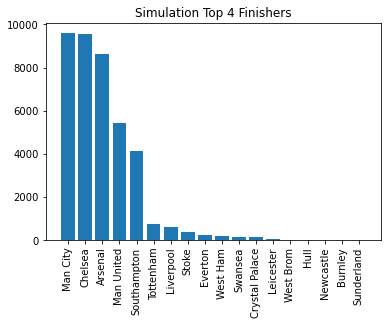

In [22]:
### Top 4 finishers

top4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), top4_count]).T, columns = ["Team", "Count"])
top4 = top4.astype({"Count": float})
top4 = top4.loc[top4["Count"] >= 1]
top4 = top4.sort_values(by="Count", ascending=False)

plt.bar(top4["Team"], top4["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Top 4 Finishers");
# plt.savefig("figures/top4.jpeg", dpi=300, bbox_inches='tight');

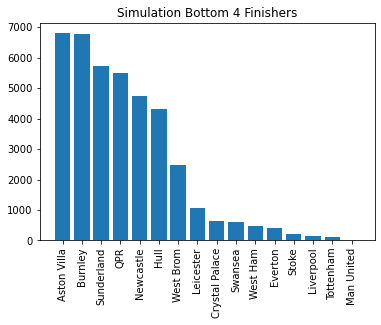

In [23]:
### Bottom 4 finishers

bottom4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), bottom4_count]).T, columns = ["Team", "Count"])
bottom4 = bottom4.astype({"Count": float})
bottom4 = bottom4.loc[bottom4["Count"] >= 1]
bottom4 = bottom4.sort_values(by="Count", ascending=False)

plt.bar(bottom4["Team"], bottom4["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Bottom 4 Finishers");
# plt.savefig("figures/bottom4.jpeg", dpi=300, bbox_inches='tight');

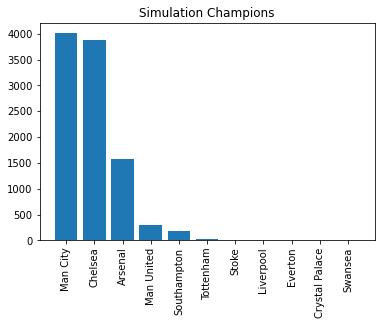

In [24]:
### League winners

winners = pd.DataFrame(data=np.array([list(teams_ind.keys()), win_count]).T, columns = ["Team", "Count"])
winners = winners.astype({"Count": float})
winners = winners.loc[winners["Count"] >= 1]
winners = winners.sort_values(by="Count", ascending=False)

plt.bar(winners["Team"], winners["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Champions");
# plt.savefig("figures/winners.jpeg",dpi=300, bbox_inches='tight')

In [15]:
### Simulate 10000 runs // MOMENTUM

num_itrs = 10000

top4_count = np.zeros(20)
win_count = np.zeros(20)
bottom4_count = np.zeros(20)

sim = df.copy(deep=True)
sim["FTHG"] = np.nan
sim["FTAG"] = np.nan
sim["FTR"] = np.nan

for i in tqdm(range(num_itrs)):
    standings = sim_with_standings_momentum(sim, team_params, streak_param, teams_ind, streaks=np.zeros((38,20), dtype=int))
    for team in get_top4(standings):
        top4_count[teams_ind[team]] += 1
    for team in get_bottom4(standings):
        bottom4_count[teams_ind[team]] += 1
    win_count[teams_ind[get_winner(standings)[1]]] += 1

100%|██████████| 10000/10000 [09:21<00:00, 17.82it/s]


In [17]:
# ### Save simulation results DON'T UNCOMMENT
# saved_sims = [win_count, top4_count, bottom4_count]
# with open('saved_data/counts_momentum.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_sims, f, pickle.HIGHEST_PROTOCOL)

In [26]:
with open('saved_data/counts_momentum.pickle', 'rb') as f:
    saved_sims = pickle.load(f)

win_count = saved_sims[0]
top4_count = saved_sims[1]
bottom4_count = saved_sims[2]

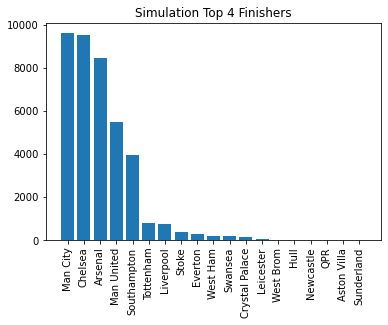

In [30]:
### Top 4 finishers

top4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), top4_count]).T, columns = ["Team", "Count"])
top4 = top4.astype({"Count": float})
top4 = top4.loc[top4["Count"] >= 1]
top4 = top4.sort_values(by="Count", ascending=False)

plt.bar(top4["Team"], top4["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Top 4 Finishers");
# plt.savefig("figures/top4_momentum.jpeg", dpi=300, bbox_inches='tight');

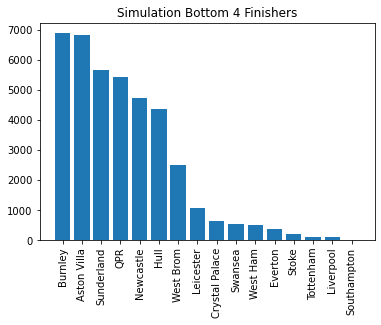

In [31]:
### Bottom 4 finishers

bottom4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), bottom4_count]).T, columns = ["Team", "Count"])
bottom4 = bottom4.astype({"Count": float})
bottom4 = bottom4.loc[bottom4["Count"] >= 1]
bottom4 = bottom4.sort_values(by="Count", ascending=False)

plt.bar(bottom4["Team"], bottom4["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Bottom 4 Finishers");
# plt.savefig("figures/bottom4_momentum.jpeg", dpi=300, bbox_inches='tight');

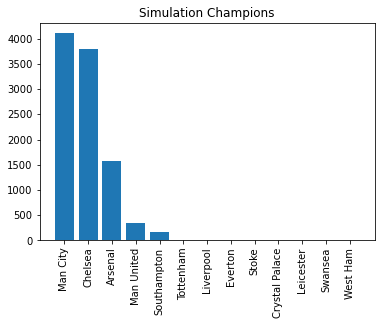

In [32]:
### League winners

winners = pd.DataFrame(data=np.array([list(teams_ind.keys()), win_count]).T, columns = ["Team", "Count"])
winners = winners.astype({"Count": float})
winners = winners.loc[winners["Count"] >= 1]
winners = winners.sort_values(by="Count", ascending=False)

plt.bar(winners["Team"], winners["Count"])
plt.xticks(rotation="vertical");
plt.title("Simulation Champions");
# plt.savefig("figures/winners_momentum.jpeg",dpi=300, bbox_inches='tight')